# Exploratory Data Analysis: Bank Customer Analytics

This notebook performs comprehensive EDA on the bank customer analytics dataset to understand:
- Data characteristics and structure
- Statistical summaries
- Distributions of variables
- Correlations and relationships
- Data quality issues

The goal is to prepare the data for Machine Learning modeling.

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Initial Inspection

In [2]:
# Load the dataset
df = pd.read_csv('bank_customer_analytics.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded successfully!
Shape: 3000 rows, 12 columns


In [3]:
# Display first few rows
print("First 10 rows of the dataset:")
df.head(10)

First 10 rows of the dataset:


,CustomerID,Age,Gender,MaritalStatus,Income,Savings,CreditScore,LoanAmount,LoanStatus,AccountType,YearsWithBank,Churn
0,C0001,25.00,FEMALE,single,80000.00,15000.00,600.00,50000.00,approved,joint,NaN,no
1,C0002,35.00,male,single,40000.00,5000.00,700.00,40000.00,approved,joint,10.00,no
2,C0003,35.00,female,single,100000.00,20000.00,800.00,50000.00,defaulted,checking,10.00,no
3,C0004,45.00,male,married,80000.00,20000.00,750.00,30000.00,approved,checking,NaN,no
4,C0005,45.00,male,married,40000.00,25000.00,750.00,20000.00,rejected,checking,2.00,yes
5,C0006,35.00,male,married,100000.00,20000.00,750.00,20000.00,rejected,joint,5.00,no
6,C0007,35.00,male,single,60000.00,25000.00,800.00,20000.00,approved,savings,10.00,yes
7,C0008,35.00,female,single,60000.00,25000.00,700.00,20000.00,rejected,investment,10.00,no
8,C0009,55.00,FEMALE,single,80000.00,100000.00,650.00,30000.00,rejected,joint,1.00,no
9,C0010,45.00,male,single,60000.00,10000.00,NaN,50000.00,rejected,checking,10.00,yes


In [4]:
# Display last few rows
print("Last 5 rows of the dataset:")
df.tail()

Last 5 rows of the dataset:


,CustomerID,Age,Gender,MaritalStatus,Income,Savings,CreditScore,LoanAmount,LoanStatus,AccountType,YearsWithBank,Churn
2995,C2996,35.00,female,single,80000.00,NaN,800.00,30000.00,rejected,checking,2.00,yes
2996,C2997,35.00,male,single,100000.00,25000.00,600.00,40000.00,approved,checking,5.00,no
2997,C2998,45.00,FEMALE,single,80000.00,5000.00,750.00,40000.00,approved,investment,NaN,yes
2998,C2999,45.00,FEMALE,married,80000.00,15000.00,NaN,NaN,approved,savings,5.00,no
2999,C3000,35.00,female,single,80000.00,20000.00,600.00,30000.00,approved,savings,NaN,no


In [5]:
# Random sample
print("Random sample of 10 rows:")
df.sample(10)

Random sample of 10 rows:


,CustomerID,Age,Gender,MaritalStatus,Income,Savings,CreditScore,LoanAmount,LoanStatus,AccountType,YearsWithBank,Churn
620,C0621,35.00,FEMALE,divorced,NaN,20000.00,700.00,20000.00,approved,investment,5.00,no
1724,C1725,25.00,Male,widowed,60000.00,10000.00,650.00,50000.00,approved,savings,10.00,yes
2716,C2717,35.00,male,married,80000.00,NaN,600.00,40000.00,rejected,joint,2.00,yes
1999,C2000,45.00,male,single,60000.00,20000.00,800.00,50000.00,defaulted,checking,NaN,yes
1375,C1376,45.00,FEMALE,married,40000.00,100000.00,700.00,20000.00,approved,savings,1.00,no
2229,C2230,25.00,male,single,80000.00,20000.00,800.00,40000.00,approved,savings,2.00,no
822,C0823,55.00,female,widowed,40000.00,NaN,800.00,30000.00,rejected,checking,5.00,yes
1744,C1745,45.00,male,married,NaN,25000.00,600.00,40000.00,defaulted,savings,10.00,no
682,C0683,35.00,male,married,80000.00,NaN,750.00,40000.00,rejected,investment,5.00,no
1594,C1595,45.00,female,divorced,80000.00,5000.00,750.00,30000.00,rejected,savings,1.00,no


## 3. Data Structure and Information

In [13]:
# Dataset info
print("Dataset Information:")
print("="*60)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     3000 non-null   object 
 1   Age            2838 non-null   float64
 2   Gender         3000 non-null   object 
 3   MaritalStatus  3000 non-null   object 
 4   Income         2865 non-null   float64
 5   Savings        2854 non-null   float64
 6   CreditScore    2857 non-null   float64
 7   LoanAmount     2867 non-null   float64
 8   LoanStatus     3000 non-null   object 
 9   AccountType    3000 non-null   object 
 10  YearsWithBank  2713 non-null   float64
 11  Churn          3000 non-null   object 
dtypes: float64(6), object(6)
memory usage: 281.4+ KB


In [10]:
# Data types
print("Data Types:")
print("="*60)
print(df.dtypes)
print("\nData Type Counts:")
print(df.dtypes.value_counts())

Data Types:
CustomerID        object
Age              float64
Gender            object
MaritalStatus     object
Income           float64
Savings          float64
CreditScore      float64
LoanAmount       float64
LoanStatus        object
AccountType       object
YearsWithBank    float64
Churn             object
dtype: object

Data Type Counts:
object     6
float64    6
Name: count, dtype: int64


In [11]:
# Column names
print("Column Names:")
print("="*60)
print(df.columns.tolist())

Column Names:
['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'Income', 'Savings', 'CreditScore', 'LoanAmount', 'LoanStatus', 'AccountType', 'YearsWithBank', 'Churn']


## 4. Data Cleaning - Fix Inconsistencies

Before proceeding with analysis, we need to fix any data quality issues such as case sensitivity in categorical variables.

In [ ]:
# Check for and fix case sensitivity issues in categorical columns
print("Data Cleaning - Fixing Inconsistencies:")
print("="*60)

# Check Gender column for case sensitivity issues
print("\nBEFORE cleaning - Gender column:")
print(df['Gender'].value_counts())
print(f"Unique values: {df['Gender'].unique()}")

# Standardize Gender column to proper capitalization
df['Gender'] = df['Gender'].str.lower().str.capitalize()

# After fixing
print("\nAFTER cleaning - Gender column:")
print(df['Gender'].value_counts())
print(f"Unique values: {df['Gender'].unique()}")

Data Cleaning - Fixing Inconsistencies:

BEFORE cleaning - Gender column:
Gender
female    889
male      871
FEMALE    632
Male      608
Name: count, dtype: int64
Unique values: ['FEMALE' 'male' 'female' 'Male']

AFTER cleaning - Gender column:
Gender
Female    1521
Male      1479
Name: count, dtype: int64
Unique values: ['Female' 'Male']

Data cleaning completed! All analyses will use cleaned data.


## 5. Missing Values Analysis

In [15]:
# Missing values count and percentage
print("Missing Values Analysis:")
print("="*60)

missing_data = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    by='Missing_Percentage', ascending=False
)

if len(missing_data) > 0:
    print(missing_data)
else:
    print("No missing values found!")

Missing Values Analysis:
               Missing_Count  Missing_Percentage
YearsWithBank            287                9.57
Age                      162                5.40
Savings                  146                4.87
CreditScore              143                4.77
Income                   135                4.50
LoanAmount               133                4.43


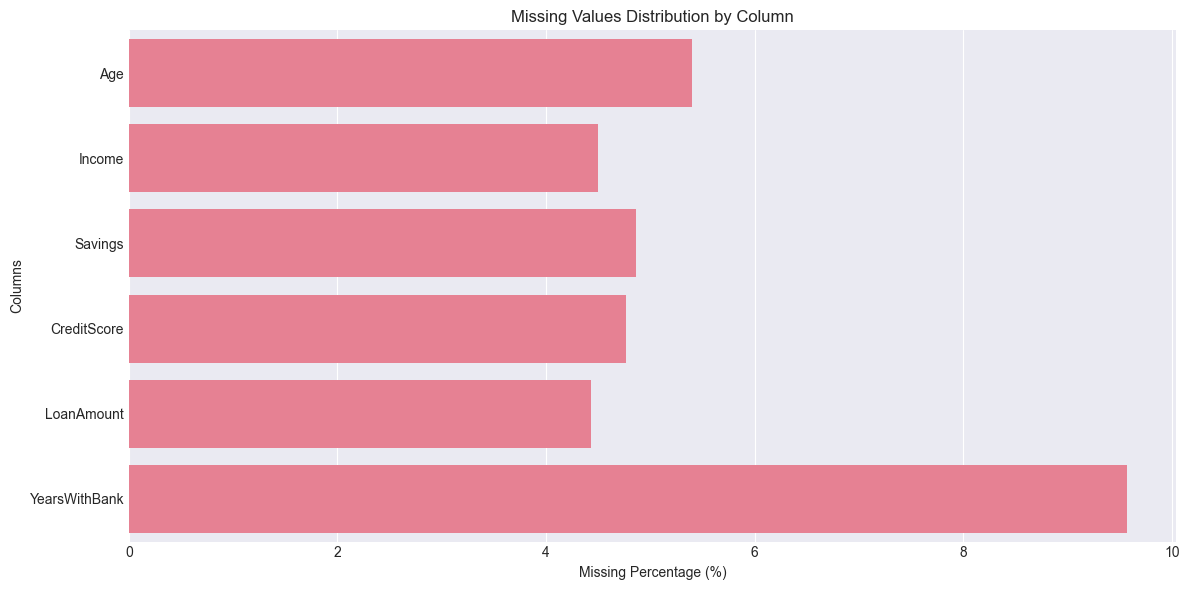

In [16]:
# Visualize missing values
if df.isnull().sum().sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_cols = df.columns[df.isnull().any()].tolist()
    missing_percentages = (df[missing_cols].isnull().sum() / len(df)) * 100
    
    sns.barplot(x=missing_percentages.values, y=missing_percentages.index, orient='h')
    plt.xlabel('Missing Percentage (%)')
    plt.ylabel('Columns')
    plt.title('Missing Values Distribution by Column')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values to visualize.")

## 6. Statistical Summary

In [17]:
# Statistical summary for numerical columns
print("Statistical Summary - Numerical Features:")
print("="*60)
df.describe()

Statistical Summary - Numerical Features:


,Age,Income,Savings,CreditScore,LoanAmount,YearsWithBank
count,2838.00,2865.00,2854.00,2857.00,2867.00,2713.00
mean,39.05,68293.19,21483.88,694.66,34080.92,6.88
std,9.82,19997.85,20893.05,68.91,9972.98,5.91
min,25.00,40000.00,5000.00,600.00,20000.00,1.00
25%,35.00,60000.00,10000.00,650.00,30000.00,2.00
50%,35.00,60000.00,15000.00,700.00,30000.00,5.00
75%,45.00,80000.00,20000.00,750.00,40000.00,10.00
max,55.00,100000.00,200000.00,800.00,50000.00,100.00


In [18]:
# Extended statistics including skewness and kurtosis
print("Extended Statistical Summary:")
print("="*60)

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

extended_stats = pd.DataFrame({
    'Mean': df[numerical_cols].mean(),
    'Median': df[numerical_cols].median(),
    'Std': df[numerical_cols].std(),
    'Variance': df[numerical_cols].var(),
    'Skewness': df[numerical_cols].skew(),
    'Kurtosis': df[numerical_cols].kurtosis()
})

extended_stats

Extended Statistical Summary:


,Mean,Median,Std,Variance,Skewness,Kurtosis
Age,39.05,35.00,9.82,96.36,0.05,-1.02
Income,68293.19,60000.00,19997.85,399914007.43,0.07,-1.06
Savings,21483.88,15000.00,20893.05,436519719.10,2.97,9.28
CreditScore,694.66,700.00,68.91,4748.28,0.06,-1.26
LoanAmount,34080.92,30000.00,9972.98,99460302.29,0.05,-1.06
YearsWithBank,6.88,5.00,5.91,34.90,2.50,22.82


In [19]:
# Statistical summary for categorical columns
print("Statistical Summary - Categorical Features:")
print("="*60)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    df[categorical_cols].describe()

Statistical Summary - Categorical Features:


## 7. Unique Values and Cardinality

In [20]:
# Unique values count for all columns
print("Unique Values Count:")
print("="*60)

unique_counts = pd.DataFrame({
    'Column': df.columns,
    'Unique_Count': [df[col].nunique() for col in df.columns],
    'Unique_Percentage': [(df[col].nunique() / len(df)) * 100 for col in df.columns]
})

unique_counts = unique_counts.sort_values(by='Unique_Count', ascending=False)
unique_counts

Unique Values Count:


,Column,Unique_Count,Unique_Percentage
0,CustomerID,3000,100.00
5,Savings,8,0.27
10,YearsWithBank,6,0.20
6,CreditScore,5,0.17
7,LoanAmount,4,0.13
3,MaritalStatus,4,0.13
1,Age,4,0.13
4,Income,4,0.13
9,AccountType,4,0.13
8,LoanStatus,3,0.10


In [21]:
# Value counts for categorical variables
print("Value Counts for Categorical Variables:")
print("="*60)

for col in categorical_cols:
    print(f"\n{col}:")
    print("-" * 40)
    print(df[col].value_counts())
    print(f"\nPercentage distribution:")
    print(df[col].value_counts(normalize=True) * 100)

Value Counts for Categorical Variables:

CustomerID:
----------------------------------------
CustomerID
C0001    1
C0002    1
C0003    1
C0004    1
C0005    1
        ..
C2996    1
C2997    1
C2998    1
C2999    1
C3000    1
Name: count, Length: 3000, dtype: int64

Percentage distribution:
CustomerID
C0001   0.03
C0002   0.03
C0003   0.03
C0004   0.03
C0005   0.03
        ... 
C2996   0.03
C2997   0.03
C2998   0.03
C2999   0.03
C3000   0.03
Name: proportion, Length: 3000, dtype: float64

Gender:
----------------------------------------
Gender
Female    1521
Male      1479
Name: count, dtype: int64

Percentage distribution:
Gender
Female   50.70
Male     49.30
Name: proportion, dtype: float64

MaritalStatus:
----------------------------------------
MaritalStatus
single      1216
married     1213
widowed      301
divorced     270
Name: count, dtype: int64

Percentage distribution:
MaritalStatus
single     40.53
married    40.43
widowed    10.03
divorced    9.00
Name: proportion, dtype: 

## 8. Distribution Analysis - Numerical Features

Distribution of Numerical Features:


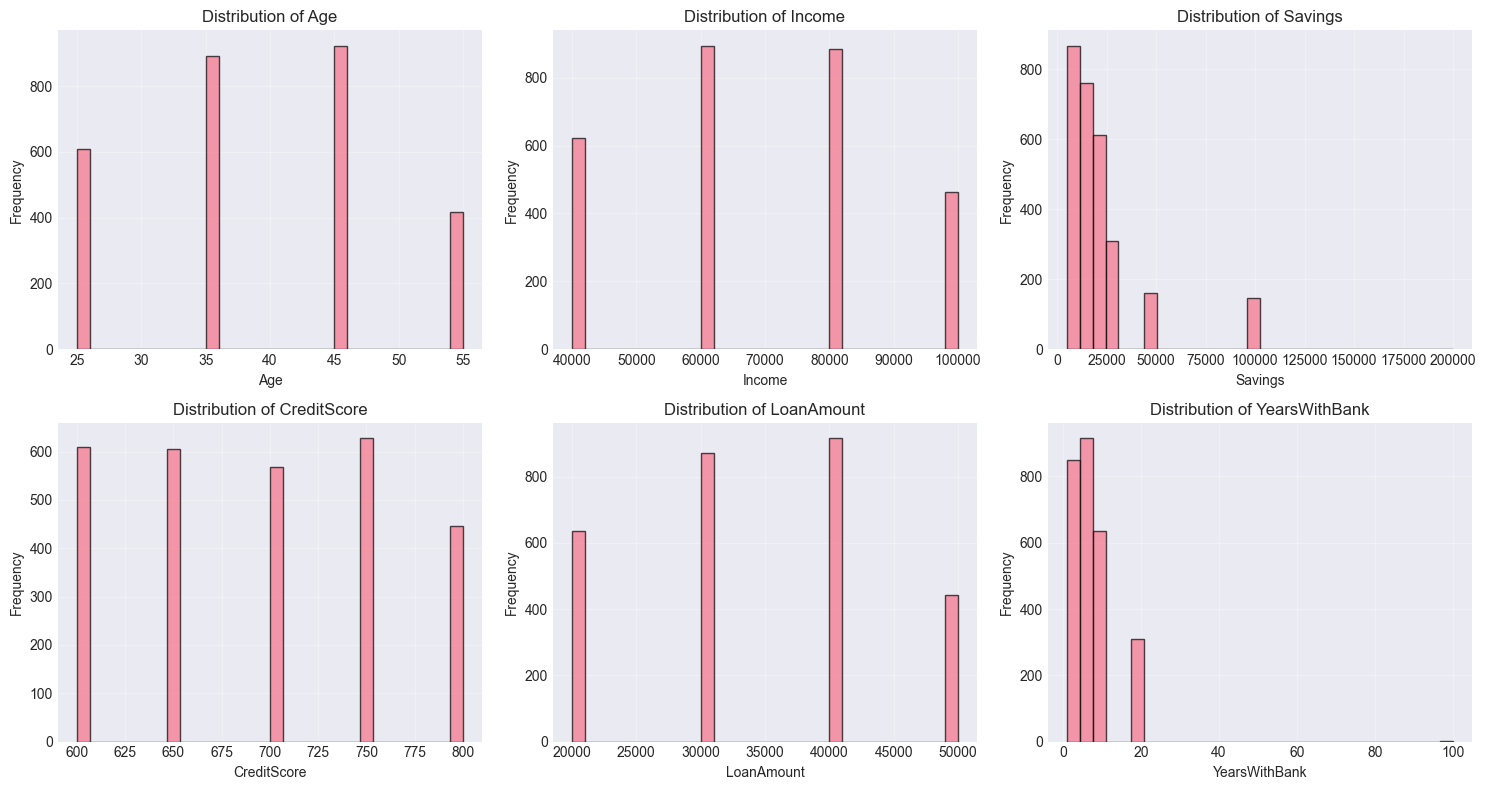

In [22]:
# Histograms for all numerical features
print("Distribution of Numerical Features:")

numerical_cols_clean = [col for col in numerical_cols if col != 'CustomerID']
n_cols = 3
n_rows = (len(numerical_cols_clean) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols_clean):
    ax = axes[idx]
    df[col].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_cols_clean), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

Box Plots - Outlier Detection:


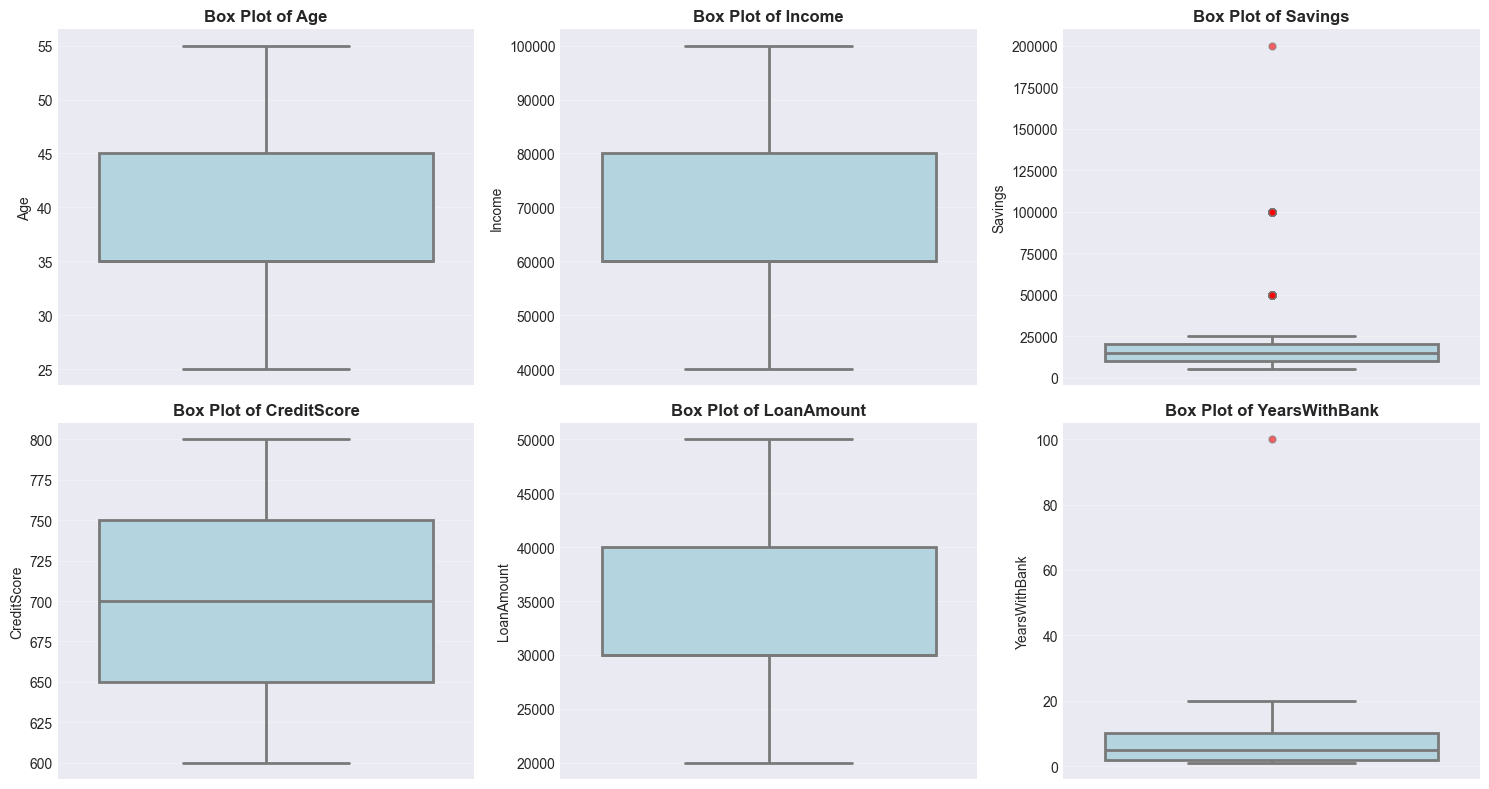

In [23]:
# Box plots for numerical features to identify outliers
print("Box Plots - Outlier Detection:")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols_clean):
    ax = axes[idx]
    # Use seaborn boxplot for better visibility
    sns.boxplot(y=df[col], ax=ax, color='lightblue', linewidth=2, 
                flierprops=dict(markerfacecolor='red', marker='o', markersize=5, alpha=0.6))
    ax.set_title(f'Box Plot of {col}', fontweight='bold')
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(len(numerical_cols_clean), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

Kernel Density Estimation Plots:


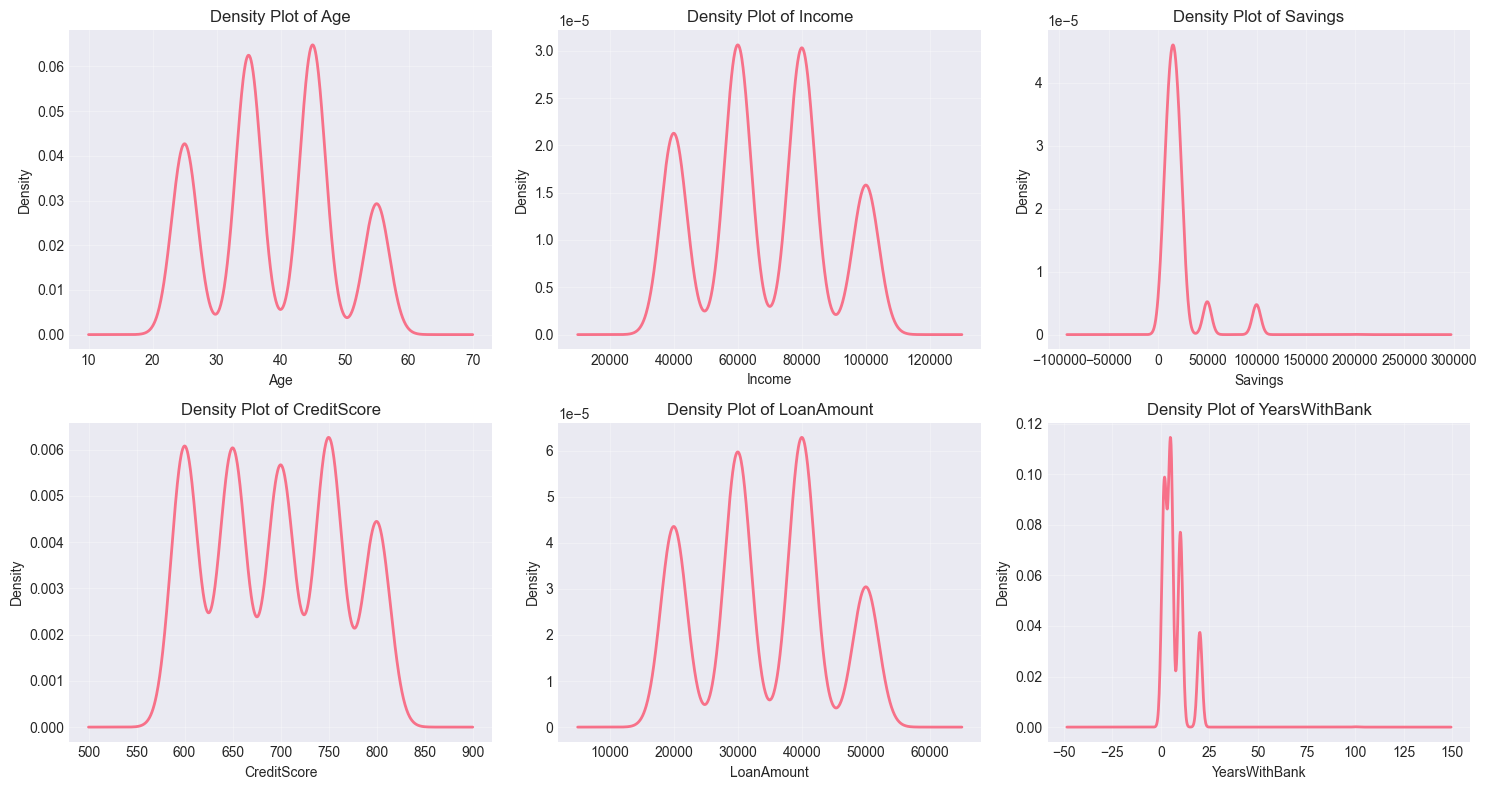

In [24]:
# Density plots (KDE)
print("Kernel Density Estimation Plots:")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols_clean):
    ax = axes[idx]
    df[col].dropna().plot(kind='kde', ax=ax, linewidth=2)
    ax.set_title(f'Density Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_cols_clean), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

Q-Q Plots - Normality Check:


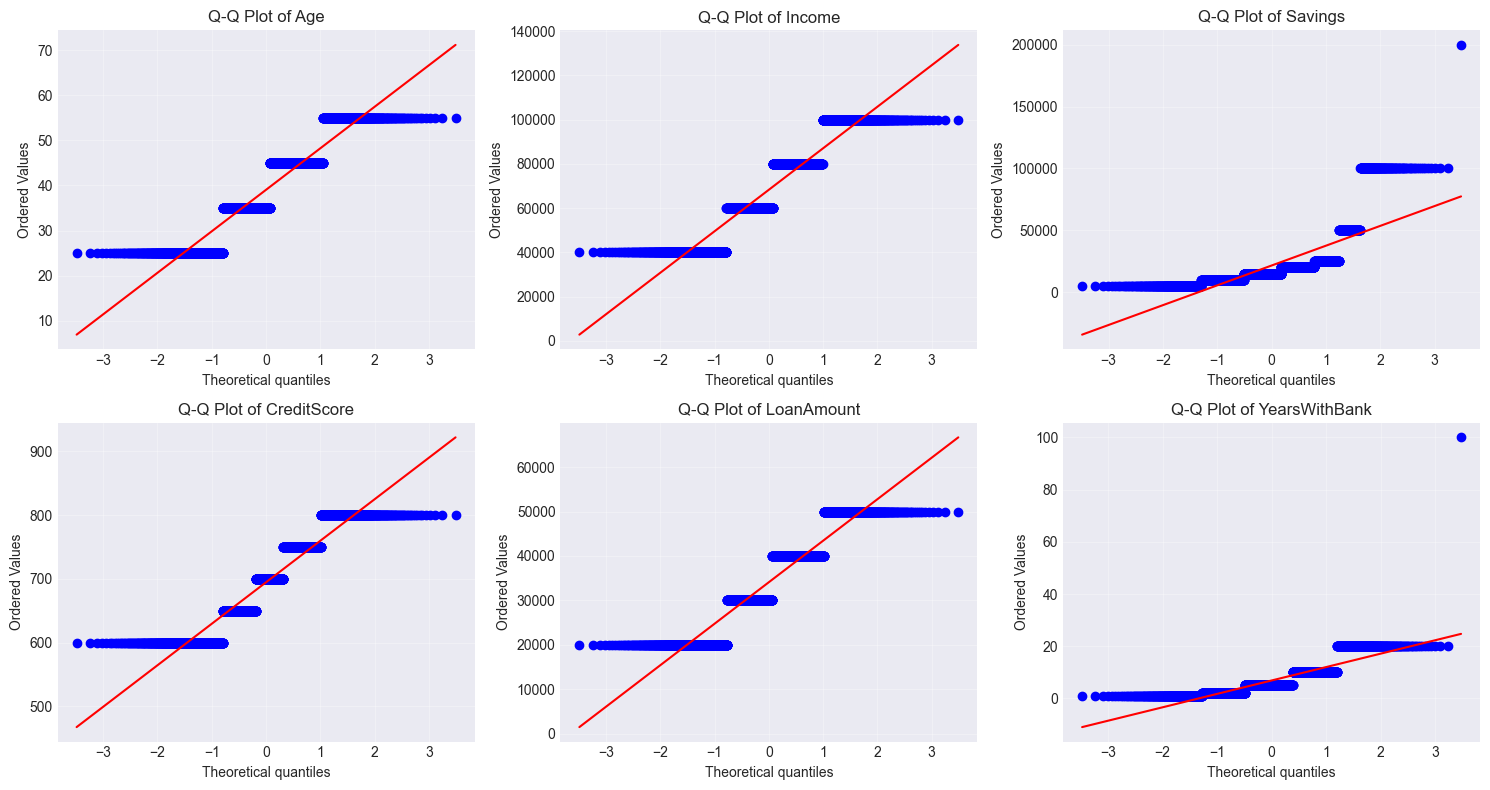

In [25]:
# Q-Q plots to check normality
print("Q-Q Plots - Normality Check:")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols_clean):
    ax = axes[idx]
    stats.probplot(df[col].dropna(), dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot of {col}')
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_cols_clean), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 9. Distribution Analysis - Categorical Features

Distribution of Categorical Features:


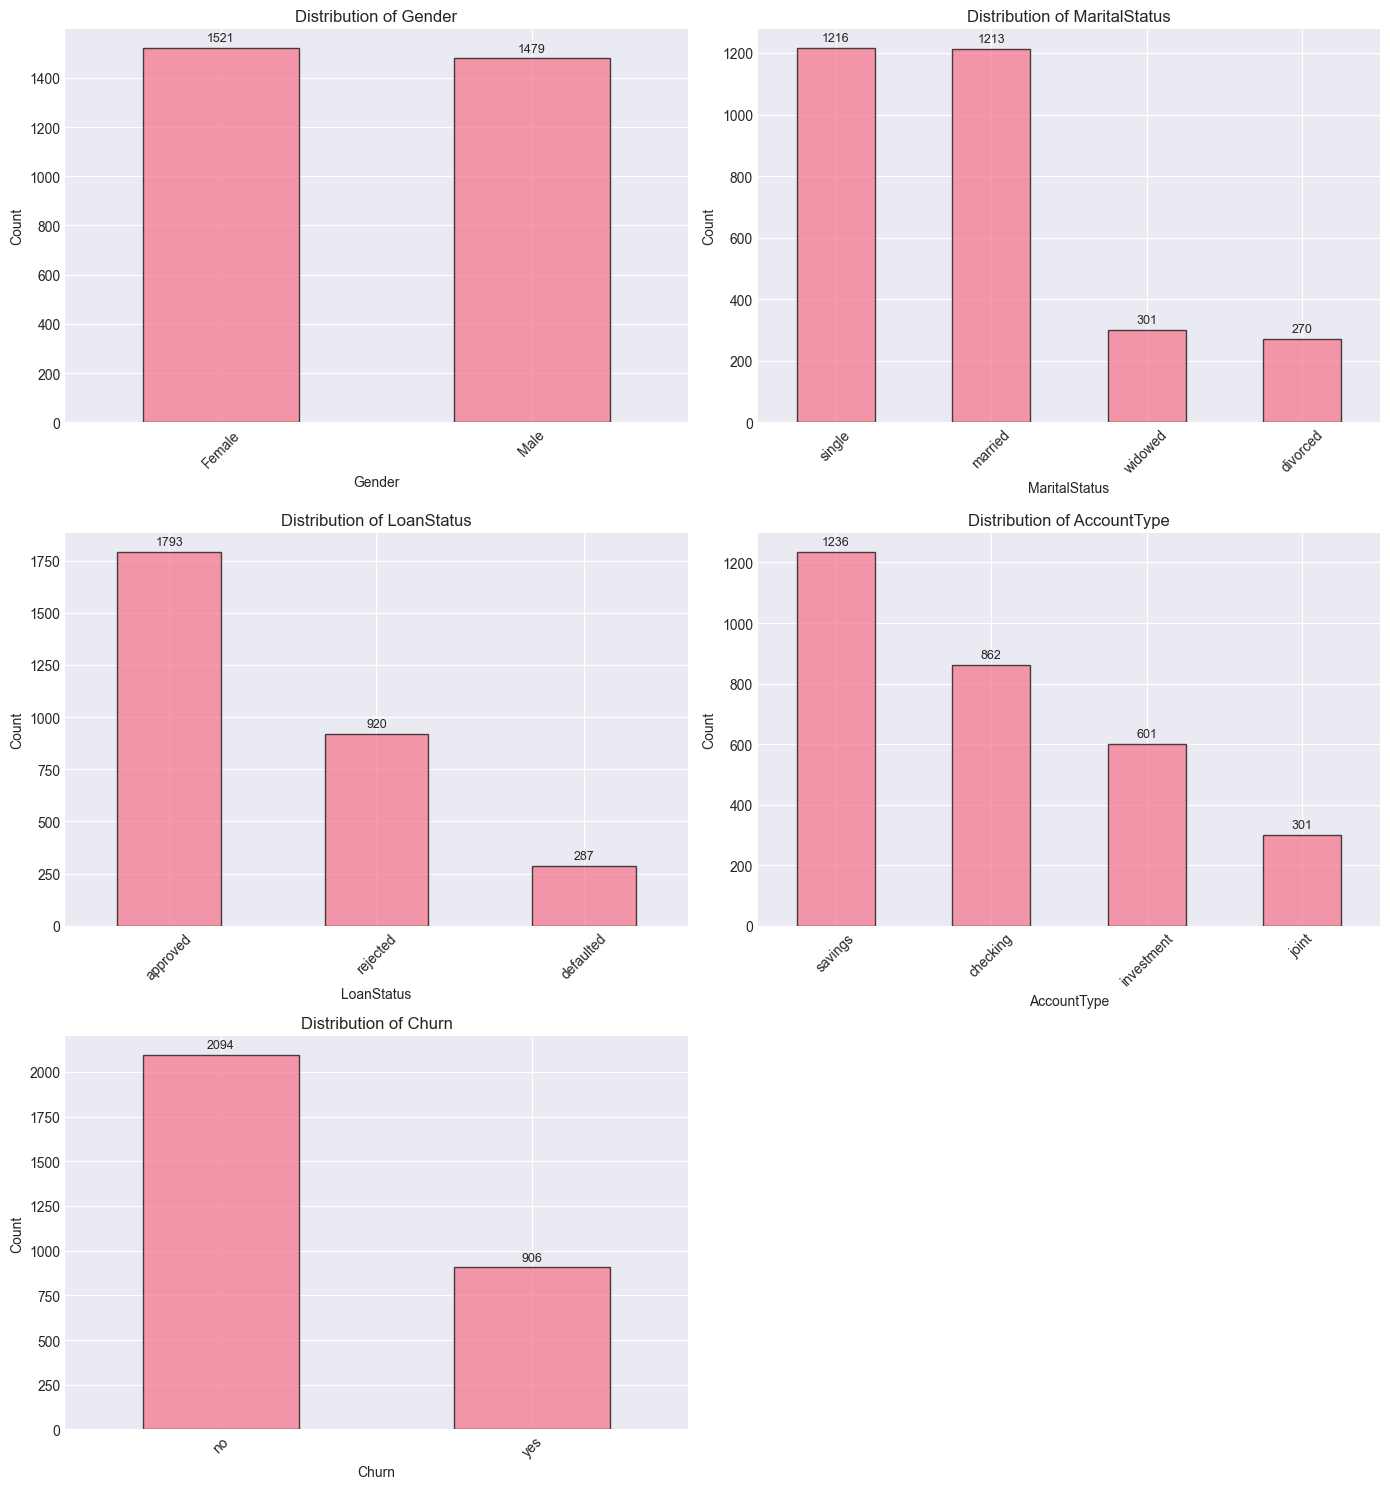

In [26]:
# Bar plots for categorical variables
print("Distribution of Categorical Features:")

categorical_cols_clean = [col for col in categorical_cols if col != 'CustomerID']

if categorical_cols_clean:
    n_cols_cat = 2
    n_rows_cat = (len(categorical_cols_clean) + n_cols_cat - 1) // n_cols_cat
    
    fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(14, n_rows_cat * 5))
    axes = axes.flatten() if n_rows_cat > 1 else [axes]
    
    for idx, col in enumerate(categorical_cols_clean):
        ax = axes[idx]
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, v in enumerate(value_counts.values):
            ax.text(i, v + max(value_counts.values) * 0.01, str(v), 
                   ha='center', va='bottom', fontsize=9)
    
    # Hide extra subplots
    for idx in range(len(categorical_cols_clean), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Pie Charts - Categorical Features:


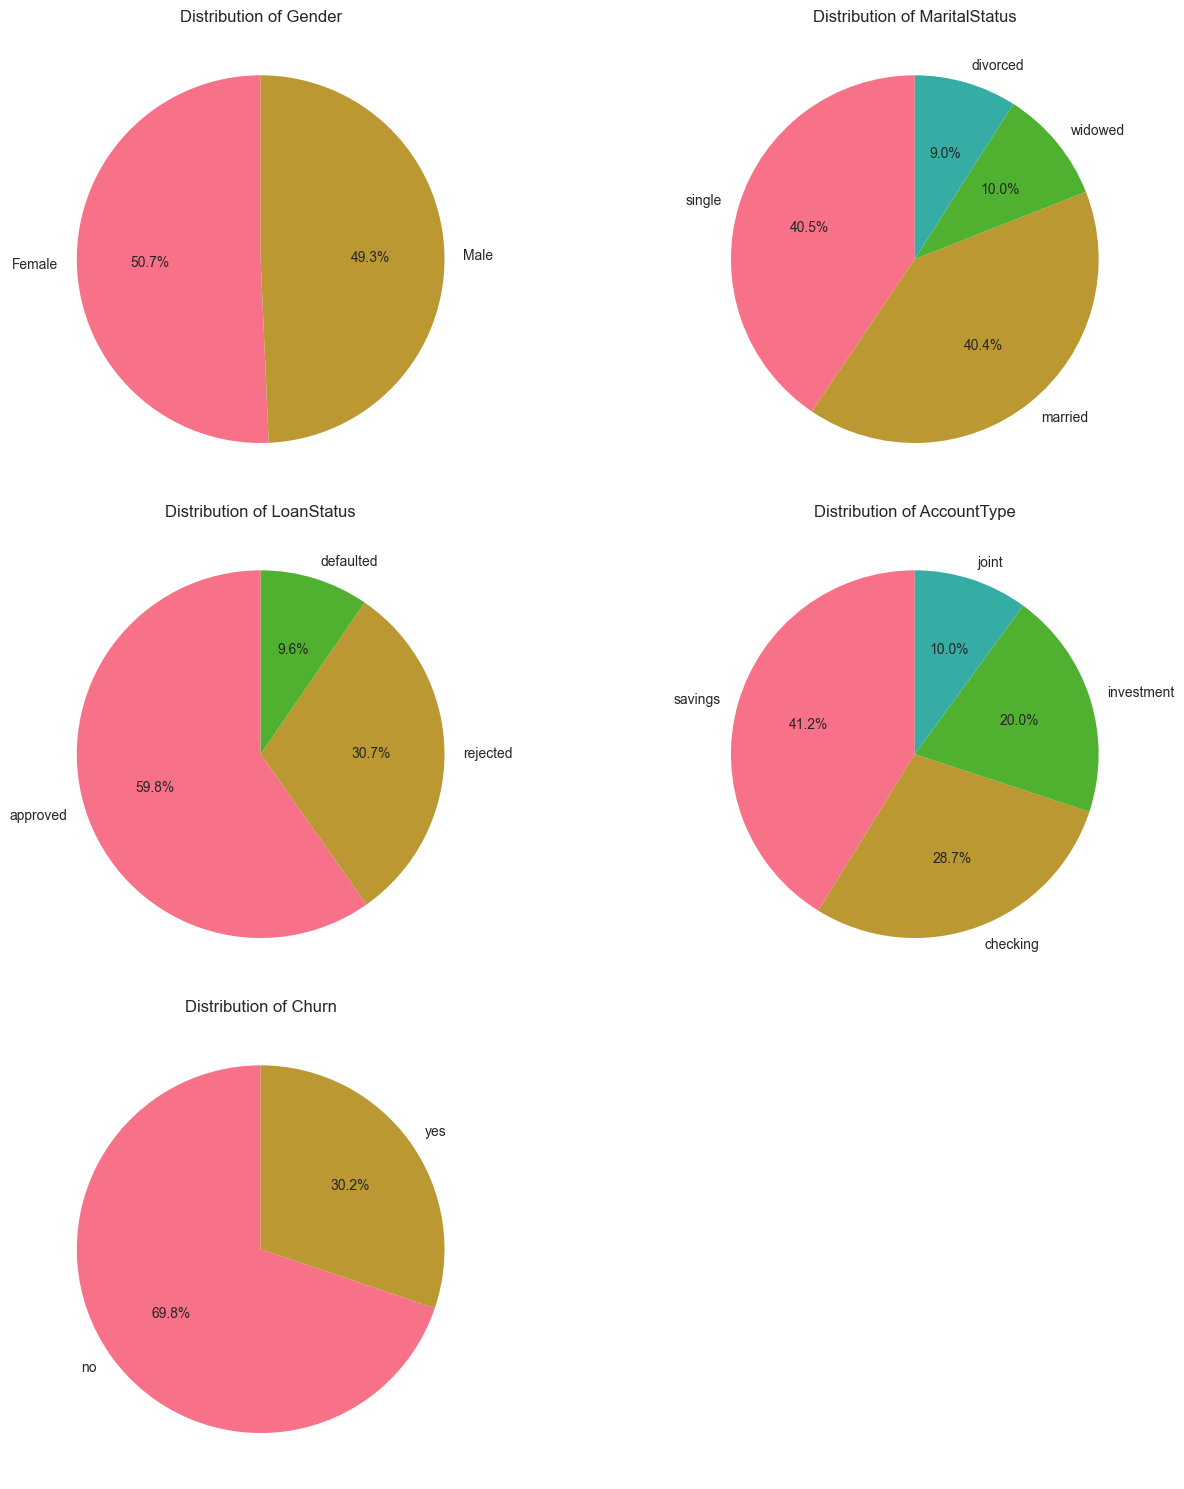

In [27]:
# Pie charts for categorical variables
print("Pie Charts - Categorical Features:")

if categorical_cols_clean:
    fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(14, n_rows_cat * 5))
    axes = axes.flatten() if n_rows_cat > 1 else [axes]
    
    for idx, col in enumerate(categorical_cols_clean):
        ax = axes[idx]
        value_counts = df[col].value_counts()
        ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%',
               startangle=90, textprops={'fontsize': 10})
        ax.set_title(f'Distribution of {col}')
    
    # Hide extra subplots
    for idx in range(len(categorical_cols_clean), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## 10. Correlation Analysis

In [28]:
# Correlation matrix for numerical features
print("Correlation Matrix - Numerical Features:")
print("="*60)

correlation_matrix = df[numerical_cols_clean].corr()
correlation_matrix

Correlation Matrix - Numerical Features:


,Age,Income,Savings,CreditScore,LoanAmount,YearsWithBank
Age,1.00,0.00,-0.02,-0.03,0.01,0.02
Income,0.00,1.00,-0.02,0.02,0.03,0.02
Savings,-0.02,-0.02,1.00,-0.01,-0.02,0.03
CreditScore,-0.03,0.02,-0.01,1.00,-0.02,-0.02
LoanAmount,0.01,0.03,-0.02,-0.02,1.00,-0.04
YearsWithBank,0.02,0.02,0.03,-0.02,-0.04,1.00


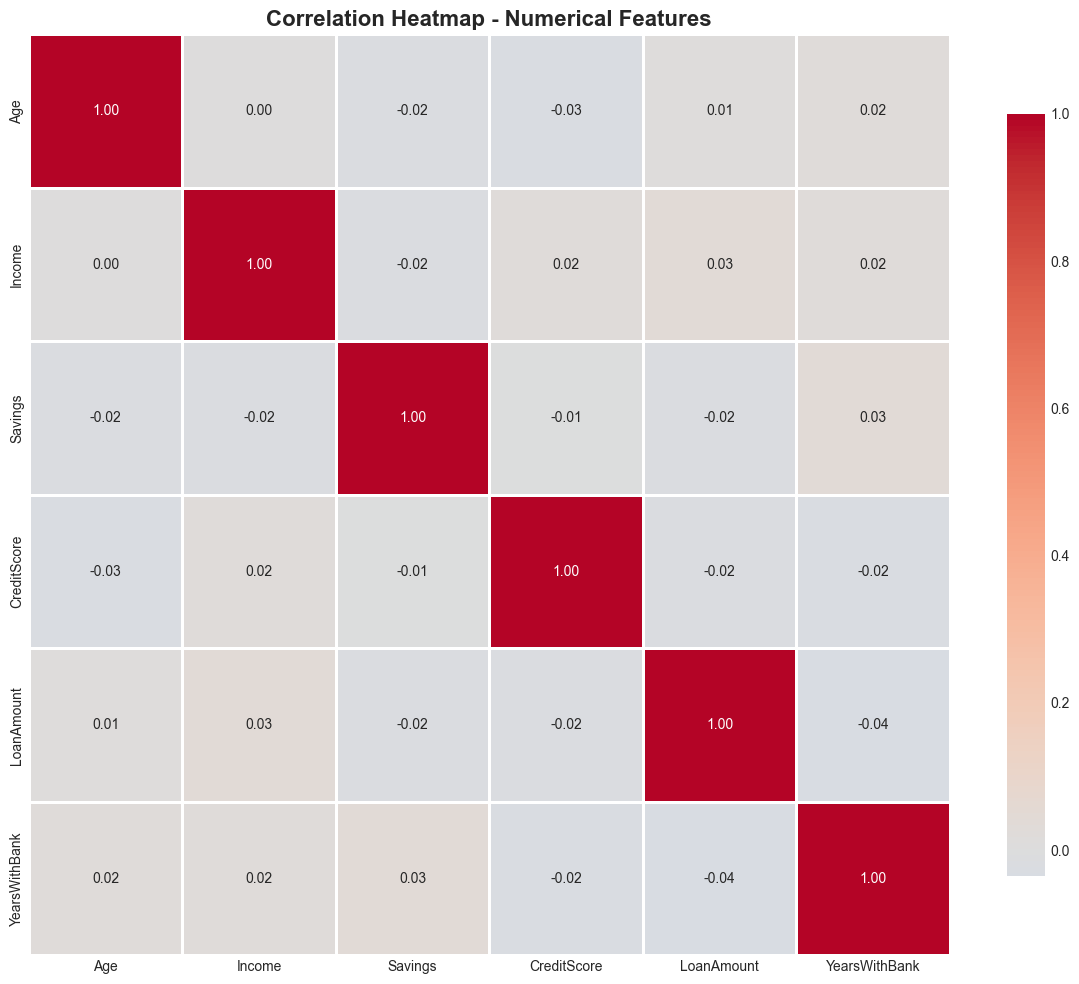

In [29]:
# Heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Outlier Analysis

In [30]:
# Detect outliers using IQR method
print("Outlier Detection using IQR Method:")
print("="*60)

outlier_summary = []

for col in numerical_cols_clean:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': len(outliers),
        'Outlier_Percentage': (len(outliers) / len(df)) * 100,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df[outlier_df['Outlier_Count'] > 0].sort_values(
    by='Outlier_Percentage', ascending=False
)

if len(outlier_df) > 0:
    print(outlier_df)
else:
    print("No outliers detected using IQR method.")

Outlier Detection using IQR Method:
         Feature  Outlier_Count  Outlier_Percentage  Lower_Bound  Upper_Bound
2        Savings            305               10.17     -5000.00     35000.00
5  YearsWithBank              1                0.03       -10.00        22.00


Categorical vs Numerical Analysis:


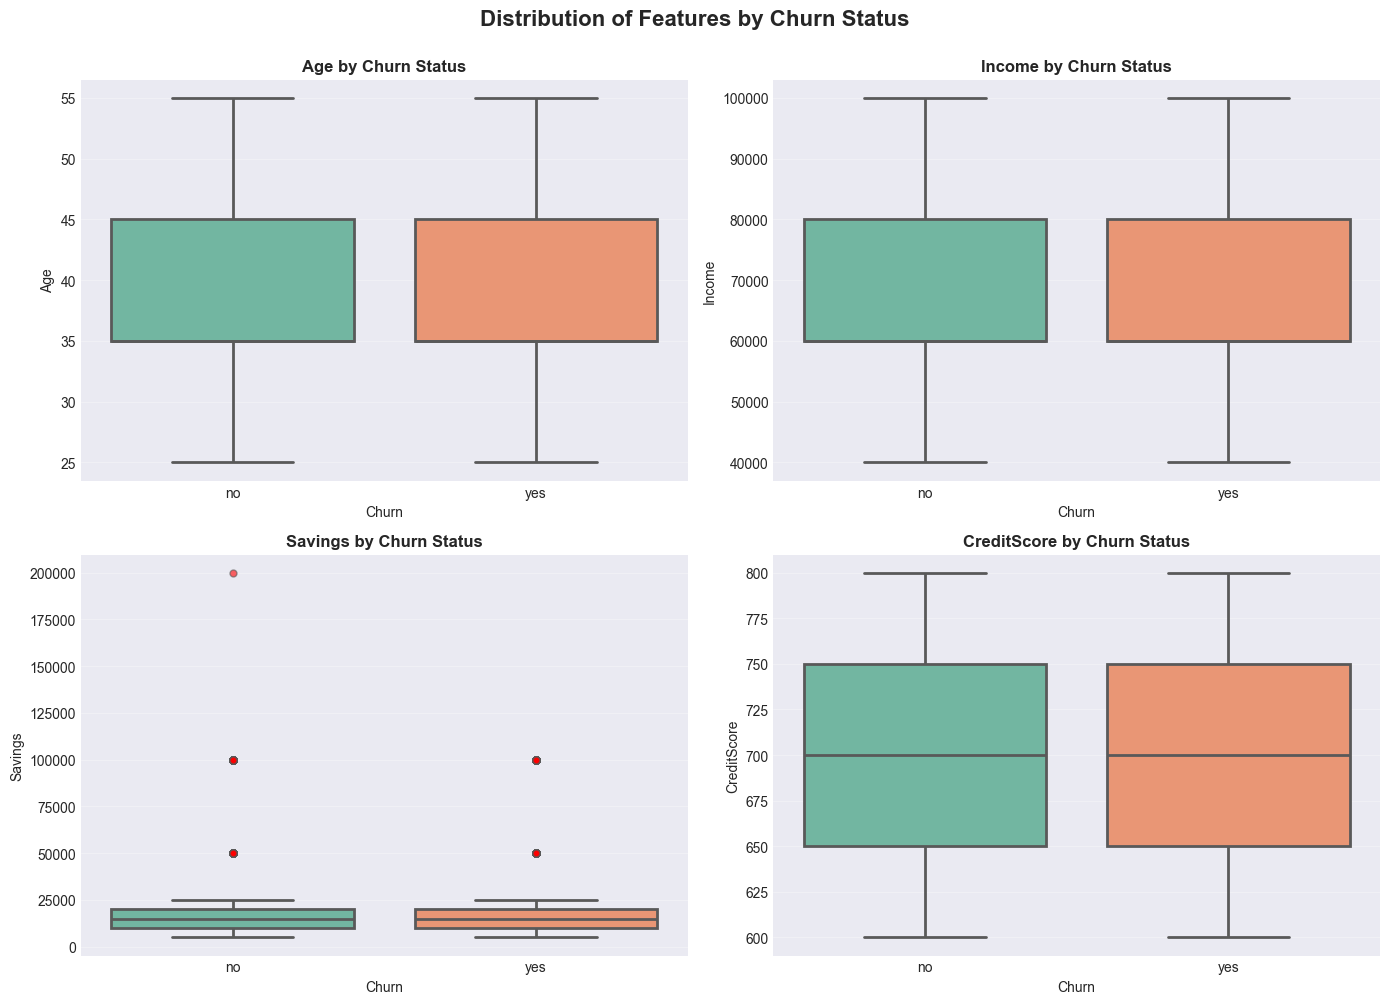

In [31]:
# Categorical vs Numerical analysis
print("Categorical vs Numerical Analysis:")

# Example: Churn vs numerical features
if 'Churn' in df.columns and len(numerical_cols_clean) > 0:
    n_features = min(4, len(numerical_cols_clean))
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(numerical_cols_clean[:n_features]):
        # Use seaborn boxplot for better visibility
        sns.boxplot(x='Churn', y=col, data=df, ax=axes[idx], 
                   palette='Set2', linewidth=2,
                   flierprops=dict(markerfacecolor='red', marker='o', markersize=5, alpha=0.6))
        axes[idx].set_title(f'{col} by Churn Status', fontweight='bold')
        axes[idx].set_xlabel('Churn')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Distribution of Features by Churn Status', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

Categorical vs Categorical Analysis:

Gender vs Churn (percentage):
Churn     no   yes
Gender            
Female 69.63 30.37
Male   69.98 30.02


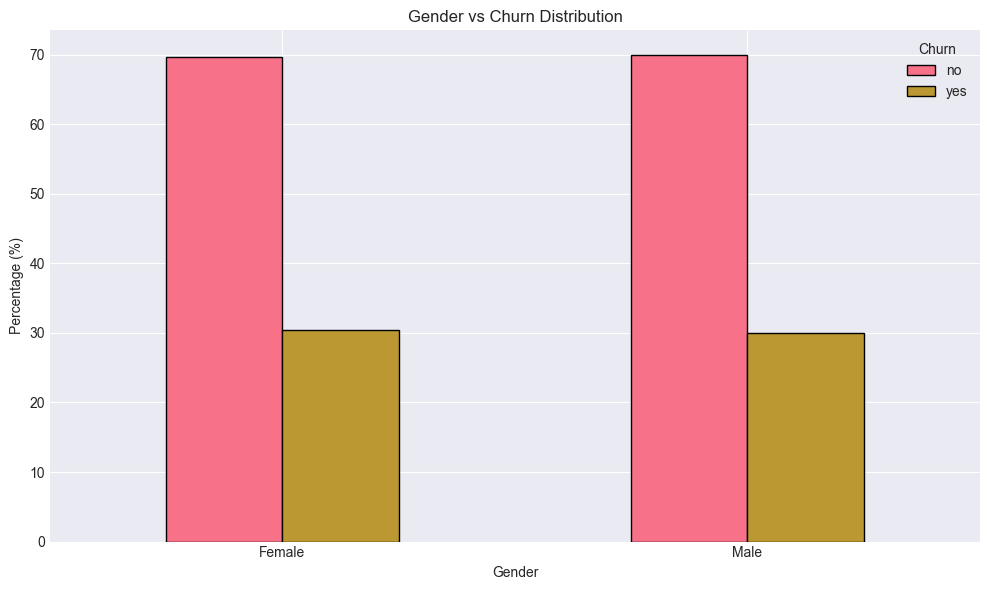

In [32]:
# Categorical vs Categorical analysis
print("Categorical vs Categorical Analysis:")

# Example: Cross-tabulation
if 'Gender' in df.columns and 'Churn' in df.columns:
    ct = pd.crosstab(df['Gender'], df['Churn'], normalize='index') * 100
    print("\nGender vs Churn (percentage):")
    print(ct)
    
    ct.plot(kind='bar', stacked=False, figsize=(10, 6), edgecolor='black')
    plt.title('Gender vs Churn Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Churn')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 12. Data Quality Issues

In [33]:
# Check for duplicate rows
print("Duplicate Rows Analysis:")
print("="*60)

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
print(f"Percentage of duplicates: {(duplicate_count / len(df)) * 100:.2f}%")

if duplicate_count > 0:
    print("\nSample duplicate rows:")
    print(df[df.duplicated(keep=False)].head(10))

Duplicate Rows Analysis:
Number of duplicate rows: 0
Percentage of duplicates: 0.00%


In [34]:
# Check for inconsistencies in categorical data
print("Data Consistency Check - Categorical Variables:")
print("="*60)

for col in categorical_cols:
    print(f"\n{col}:")
    print("-" * 40)
    unique_values = df[col].unique()
    print(f"Unique values: {unique_values}")
    
    # Check for potential case sensitivity issues
    if df[col].dtype == 'object':
        lower_unique = df[col].str.lower().unique() if df[col].notna().any() else []
        if len(lower_unique) < len(unique_values):
            print(f"WARNING: Potential case sensitivity issues detected!")
            print(f"Unique values (case-insensitive): {lower_unique}")

Data Consistency Check - Categorical Variables:

CustomerID:
----------------------------------------
Unique values: ['C0001' 'C0002' 'C0003' ... 'C2998' 'C2999' 'C3000']

Gender:
----------------------------------------
Unique values: ['Female' 'Male']

MaritalStatus:
----------------------------------------
Unique values: ['single' 'married' 'divorced' 'widowed']

LoanStatus:
----------------------------------------
Unique values: ['approved' 'defaulted' 'rejected']

AccountType:
----------------------------------------
Unique values: ['joint' 'checking' 'savings' 'investment']

Churn:
----------------------------------------
Unique values: ['no' 'yes']


## 13. Summary and Key Insights

In [37]:
print("="*80)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*80)

print(f"\n1. DATASET OVERVIEW")
print("-" * 60)
print(f"   - Total Rows: {df.shape[0]}")
print(f"   - Total Columns: {df.shape[1]}")
print(f"   - Numerical Features: {len(numerical_cols)}")
print(f"   - Categorical Features: {len(categorical_cols)}")

print(f"\n2. DATA QUALITY")
print("-" * 60)
total_missing = df.isnull().sum().sum()
print(f"   - Total Missing Values: {total_missing}")
print(f"   - Missing Value Percentage: {(total_missing / (df.shape[0] * df.shape[1])) * 100:.2f}%")
print(f"   - Duplicate Rows: {df.duplicated().sum()}")

if len(outlier_df) > 0:
    print(f"\n3. OUTLIERS")
    print("-" * 60)
    for _, row in outlier_df.iterrows():
        print(f"   - {row['Feature']}: {row['Outlier_Count']} outliers ({row['Outlier_Percentage']:.2f}%)")

print(f"\n5. KEY STATISTICS")
print("-" * 60)
for col in numerical_cols_clean[:5]:  # Show top 5
    print(f"   - {col}:")
    print(f"     Mean = {df[col].mean():.2f}, Median = {df[col].median():.2f}")
    print(f"     Std = {df[col].std():.2f}, Skewness = {df[col].skew():.2f}")

EXPLORATORY DATA ANALYSIS SUMMARY

1. DATASET OVERVIEW
------------------------------------------------------------
   - Total Rows: 3000
   - Total Columns: 12
   - Numerical Features: 6
   - Categorical Features: 6

2. DATA QUALITY
------------------------------------------------------------
   - Total Missing Values: 1006
   - Missing Value Percentage: 2.79%
   - Duplicate Rows: 0

3. OUTLIERS
------------------------------------------------------------
   - Savings: 305 outliers (10.17%)
   - YearsWithBank: 1 outliers (0.03%)

5. KEY STATISTICS
------------------------------------------------------------
   - Age:
     Mean = 39.05, Median = 35.00
     Std = 9.82, Skewness = 0.05
   - Income:
     Mean = 68293.19, Median = 60000.00
     Std = 19997.85, Skewness = 0.07
   - Savings:
     Mean = 21483.88, Median = 15000.00
     Std = 20893.05, Skewness = 2.97
   - CreditScore:
     Mean = 694.66, Median = 700.00
     Std = 68.91, Skewness = 0.06
   - LoanAmount:
     Mean = 34080.92,